# CNN + Wavelet Patches for Hazelnut Defect Detection (hazelnut_1)

This notebook implements a simplified version of the IEEE paper *"A new multiscale texture surface detection method based on convolutional neural network"* using the `data/hazelnut_1` dataset.

**Key ideas we adapt:**
- Use a wavelet transform to extract a low-frequency sub-image (approximation coefficients).
- Train a CNN on **64×64 patches** extracted from images.
- For defects, sample patches around the defect region using the provided binary masks.
- Use a sliding-window strategy for image-level validation.

**Important note:** `hazelnut_1` has **only good images in `train/`**. We therefore use **defect images from `test/`** (and their masks) to create defect patches and reserve a validation split from them. This is experimental and purely for research/learning.


## 0. Setup

If needed, install dependencies and restart the kernel:

```bash
pip install PyWavelets torch torchvision
```


In [1]:
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix

try:
    import pywt
except ImportError as exc:
    raise ImportError("PyWavelets required. Install with `pip install PyWavelets`.") from exc

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
except ImportError as exc:
    raise ImportError("PyTorch required. Install with `pip install torch torchvision`.") from exc

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = Path("data/hazelnut_1")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
GT_DIR = DATA_DIR / "ground_truth"

IMG_SIZE = 256  # resize for speed
WAVELET = "db2"
PATCH_SIZE = 64

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_DIR}")


## 1. Dataset overview

In [2]:
def list_images(dir_path):
    return sorted([p for p in dir_path.iterdir() if p.suffix.lower() == ".png"])

train_good = list_images(TRAIN_DIR / "good")

test_classes = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir()])

rows = [{"split": "train", "class": "good", "count": len(train_good)}]
for cls in test_classes:
    rows.append({"split": "test", "class": cls, "count": len(list_images(TEST_DIR / cls))})

overview = pd.DataFrame(rows)
overview


,split,class,count
0,train,good,391
1,test,crack,18
2,test,cut,17
3,test,good,40
4,test,hole,18
5,test,print,17


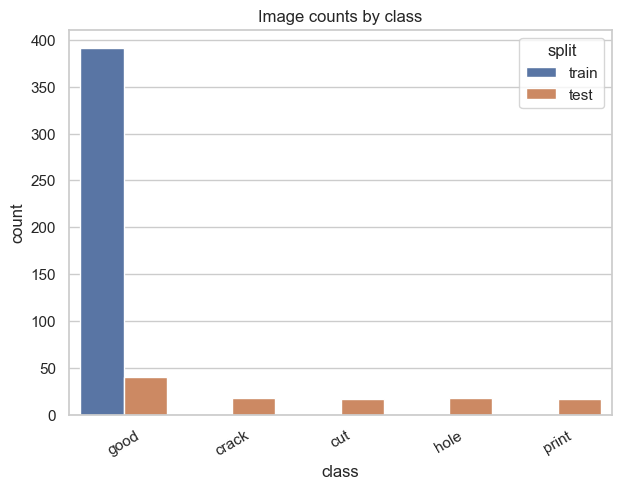

In [3]:
ax = sns.barplot(data=overview, x="class", y="count", hue="split")
ax.set_title("Image counts by class")
plt.xticks(rotation=30)
plt.show()


## 2. Wavelet preprocessing

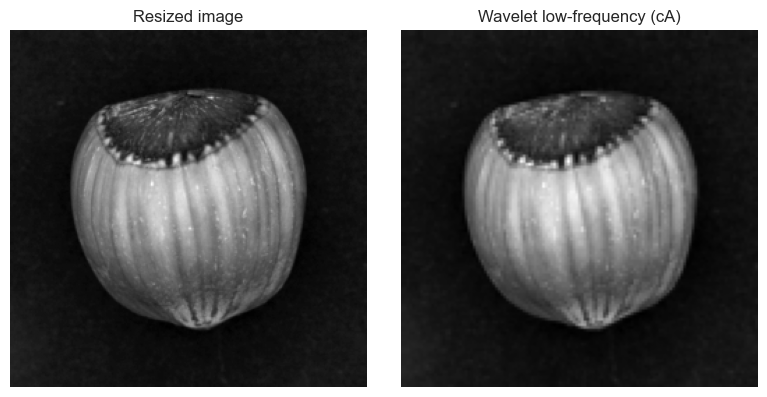

In [4]:
def load_gray(path, size=IMG_SIZE):
    img = Image.open(path).convert("L")
    if size:
        img = img.resize((size, size), Image.BILINEAR)
    return np.asarray(img, dtype=np.float32) / 255.0


def wavelet_lowfreq(img, wavelet=WAVELET):
    cA, _ = pywt.dwt2(img, wavelet=wavelet)
    return cA

sample_path = random.choice(train_good)
img = load_gray(sample_path)
low = wavelet_lowfreq(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Resized image")
axes[0].axis("off")

axes[1].imshow(low, cmap="gray")
axes[1].set_title("Wavelet low-frequency (cA)")
axes[1].axis("off")
plt.tight_layout()
plt.show()


## 3. Patch extraction (random-window + masks)

In [5]:
def load_mask(path, size):
    mask = Image.open(path).convert("L")
    mask = mask.resize((size, size), Image.NEAREST)
    return (np.asarray(mask, dtype=np.float32) > 0.5).astype(np.float32)


def extract_random_patches(img, n_patches, patch=PATCH_SIZE):
    h, w = img.shape
    patches = []
    for _ in range(n_patches):
        y = random.randint(0, h - patch)
        x = random.randint(0, w - patch)
        patches.append(img[y : y + patch, x : x + patch])
    return patches


def extract_defect_patches(img, mask, n_patches, patch=PATCH_SIZE, max_offset=16):
    h, w = img.shape
    ys, xs = np.where(mask > 0.5)
    patches = []
    if len(ys) == 0:
        return extract_random_patches(img, n_patches, patch=patch)

    for _ in range(n_patches):
        idx = random.randrange(len(ys))
        cy, cx = ys[idx], xs[idx]
        oy = random.randint(-max_offset, max_offset)
        ox = random.randint(-max_offset, max_offset)
        y = min(max(cy - patch // 2 + oy, 0), h - patch)
        x = min(max(cx - patch // 2 + ox, 0), w - patch)
        patches.append(img[y : y + patch, x : x + patch])
    return patches


def get_mask_for_image(img_path):
    cls = img_path.parent.name
    if cls == "good":
        return None
    mask_name = f"{img_path.stem}_mask.png"
    mask_path = GT_DIR / cls / mask_name
    return mask_path if mask_path.exists() else None


## 4. Build training/validation patches

In [6]:
def train_val_split(items, val_ratio=0.2):
    items = list(items)
    random.shuffle(items)
    split = int(len(items) * (1 - val_ratio))
    return items[:split], items[split:]


def build_patch_dataset(good_paths, defect_paths, patches_per_good=8, patches_per_defect=12):
    X, y = [], []
    for path in tqdm(good_paths, desc="good patches"):
        img = load_gray(path)
        low = wavelet_lowfreq(img)
        for p in extract_random_patches(low, patches_per_good):
            X.append(p)
            y.append(0)

    for path in tqdm(defect_paths, desc="defect patches"):
        img = load_gray(path)
        low = wavelet_lowfreq(img)
        mask_path = get_mask_for_image(path)
        if mask_path is None:
            continue
        mask = load_mask(mask_path, size=IMG_SIZE)
        mask_low = wavelet_lowfreq(mask)
        for p in extract_defect_patches(low, mask_low, patches_per_defect):
            X.append(p)
            y.append(1)

    X = np.stack(X).astype(np.float32)
    y = np.asarray(y, dtype=np.int64)
    return X, y

# Good images from train split
train_good = list_images(TRAIN_DIR / "good")
train_good, val_good = train_val_split(train_good, val_ratio=0.2)

# Defect images from test split (used only for experimental training/validation)
all_defects = []
for cls in test_classes:
    if cls == "good":
        continue
    all_defects.extend(list_images(TEST_DIR / cls))

train_defects, val_defects = train_val_split(all_defects, val_ratio=0.2)

X_train, y_train = build_patch_dataset(train_good, train_defects)
X_val, y_val = build_patch_dataset(val_good, val_defects)

print("Train patches:", X_train.shape, "Val patches:", X_val.shape)
print("Train defect ratio:", y_train.mean(), "Val defect ratio:", y_val.mean())


defect patches: 100%|██████████| 14/14 [00:00<00:00, 21.07it/s]

Train patches: (3168, 64, 64) Val patches: (800, 64, 64)
Train defect ratio: 0.21212121212121213 Val defect ratio: 0.21


## 5. DataLoaders

In [7]:
# Normalize using train statistics
mean = X_train.mean()
std = X_train.std() + 1e-6

X_train_n = (X_train - mean) / std
X_val_n = (X_val - mean) / std

X_train_t = torch.from_numpy(X_train_n).unsqueeze(1)
X_val_t = torch.from_numpy(X_val_n).unsqueeze(1)

y_train_t = torch.from_numpy(y_train)
y_val_t = torch.from_numpy(y_val)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)


## 6. CNN model (patch classifier)

In [8]:
class PatchCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


PatchCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

## 7. Train + validate

In [9]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_probs.extend(probs)
        all_labels.extend(yb.detach().cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else None
    return avg_loss, acc, auc

EPOCHS = 10
history = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_auc = run_epoch(train_loader, train=True)
    val_loss, val_acc, val_auc = run_epoch(val_loader, train=False)
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_auc": train_auc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_auc": val_auc,
    })
    print(
        f"Epoch {epoch:02d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.3f} auc {train_auc:.3f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.3f} auc {val_auc:.3f}"
    )

history_df = pd.DataFrame(history)
history_df


Epoch 01 | train loss 0.3697 acc 0.860 auc 0.824 | val loss 0.1519 acc 0.945 auc 0.963
Epoch 02 | train loss 0.1383 acc 0.952 auc 0.975 | val loss 0.1035 acc 0.969 auc 0.982
Epoch 03 | train loss 0.0932 acc 0.969 auc 0.991 | val loss 0.0644 acc 0.984 auc 0.991
Epoch 04 | train loss 0.0910 acc 0.970 auc 0.988 | val loss 0.0771 acc 0.973 auc 0.992
Epoch 05 | train loss 0.0590 acc 0.982 auc 0.994 | val loss 0.0693 acc 0.984 auc 0.992
Epoch 06 | train loss 0.0363 acc 0.988 auc 0.998 | val loss 0.0570 acc 0.981 auc 0.995
Epoch 07 | train loss 0.0247 acc 0.993 auc 0.999 | val loss 0.0828 acc 0.983 auc 0.995
Epoch 08 | train loss 0.0228 acc 0.992 auc 0.999 | val loss 0.0668 acc 0.983 auc 0.995
Epoch 09 | train loss 0.0256 acc 0.992 auc 0.999 | val loss 0.0735 acc 0.980 auc 0.996
Epoch 10 | train loss 0.0099 acc 0.999 auc 1.000 | val loss 0.0686 acc 0.985 auc 0.997


,epoch,train_loss,train_acc,train_auc,val_loss,val_acc,val_auc
0,1,0.369702,0.859533,0.824199,0.151883,0.94500,0.962779
1,2,0.138341,0.952020,0.975266,0.103491,0.96875,0.982331
2,3,0.093172,0.969066,0.991215,0.064412,0.98375,0.990695
3,4,0.090967,0.970328,0.988284,0.077090,0.97250,0.992409
4,5,0.059027,0.981692,0.993674,0.069306,0.98375,0.992352
5,6,0.036273,0.988321,0.998301,0.057050,0.98125,0.995206
6,7,0.024749,0.992740,0.998983,0.082753,0.98250,0.995055
7,8,0.022787,0.992109,0.999311,0.066845,0.98250,0.994547
8,9,0.025568,0.992109,0.999065,0.073490,0.98000,0.995583
9,10,0.009948,0.998737,0.999807,0.068550,0.98500,0.996553


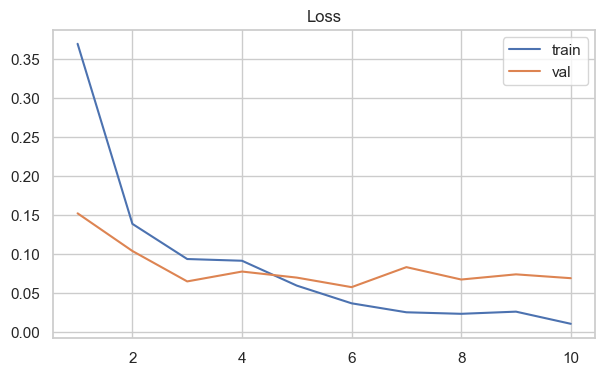

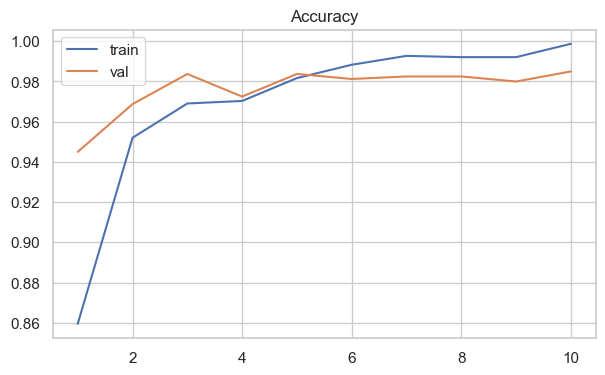

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(history_df["epoch"], history_df["train_loss"], label="train")
plt.plot(history_df["epoch"], history_df["val_loss"], label="val")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(history_df["epoch"], history_df["train_acc"], label="train")
plt.plot(history_df["epoch"], history_df["val_acc"], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()


## 8. Patch-level validation metrics

If the only consistent miss is a long, thin crack, that’s a classic “high‑frequency, low‑area” defect. A few targeted changes usually help:

What to try (most impact first)

Add wavelet detail bands (cH/cV/cD) as extra input channels, not just cA. Thin cracks live in high‑frequency detail.
Train on higher‑resolution patches or smaller patches centered on cracks (e.g., 96×96 or 128×128, or keep 64×64 but extract from full‑res 1024→512 instead of 256). Thin cracks can vanish when you downscale.
Oversample crack patches and hard‑negative mine “near‑crack” backgrounds. If cracks are rare, the network doesn’t learn them well.
Dilate/blur the crack mask before sampling defect patches so the patches include crack context and not just a tiny line.
Architecture tweaks that help thin defects

Increase receptive field without losing resolution: add a dilated conv block before pooling or reduce pooling depth (e.g., only 3 pools so features stay 8×8 instead of 4×4).
Use a light residual/attention block (SE/CBAM) to emphasize subtle features.
Try a shallow pretrained backbone (e.g., ResNet18) on 1‑channel or 4‑channel (wavelet) input.
Training/metrics tweaks

Use focal loss or class‑weighted CE to emphasize rare crack samples.
Calibrate the decision threshold separately for cracks (patch‑level and image‑level).
Add augmentations that preserve crack structure: small rotations, flips, slight contrast/CLAHE, but avoid heavy blur.
Preprocessing ideas

Edge‑enhancement or oriented filters (Sobel, Gabor) concatenated as channels.
CLAHE on the grayscale before wavelet transform to increase local contrast around the crack.

Confusion matrix (patch-level):
[[631   1]
 [ 11 157]]
ROC AUC: 0.9965528933092224
Misclassified patches: 12 / 800


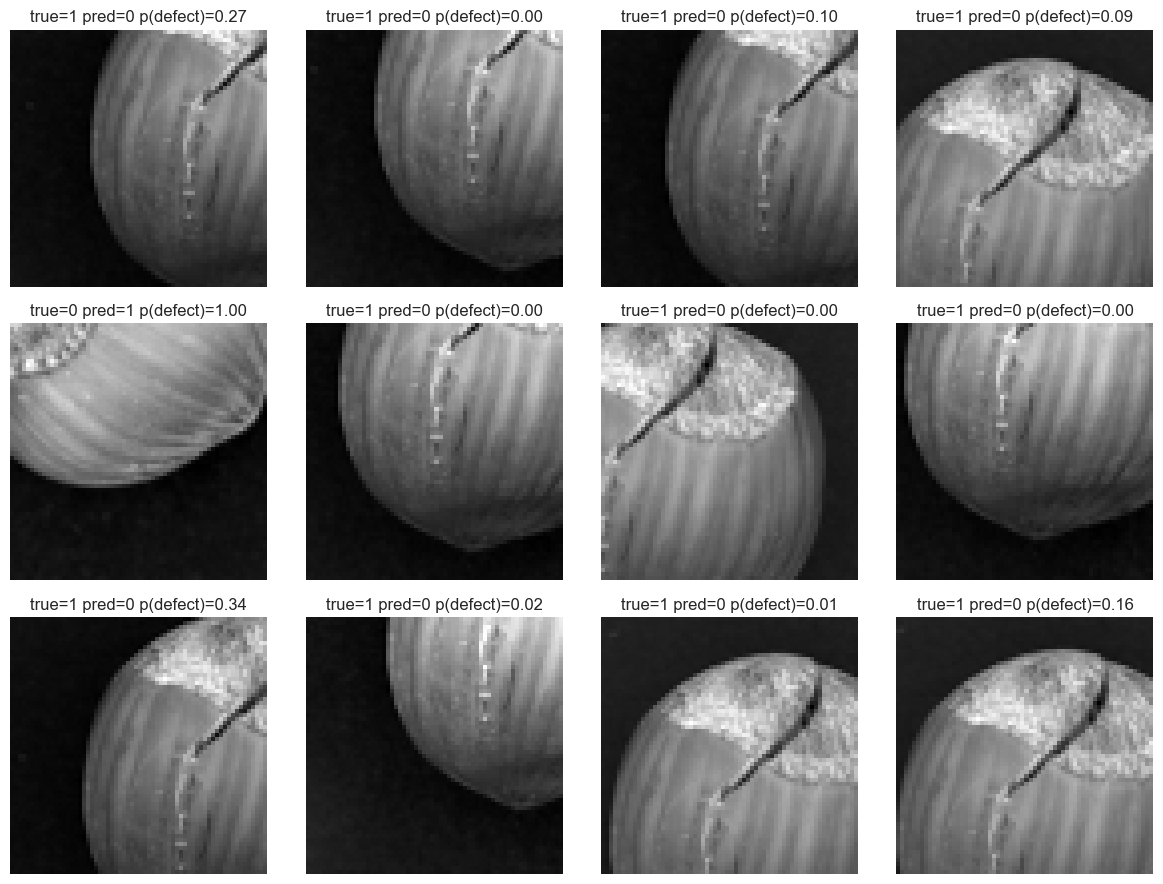

In [11]:
model.eval()
with torch.no_grad():
    logits = model(X_val_t.to(device))
    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
    preds = np.argmax(logits.cpu().numpy(), axis=1)

cm = confusion_matrix(y_val, preds)
print("Confusion matrix (patch-level):")
print(cm)
if len(np.unique(y_val)) > 1:
    print("ROC AUC:", roc_auc_score(y_val, probs))


# Show misclassified validation patches
mis_idx = np.where(preds != y_val)[0]
print(f"Misclassified patches: {len(mis_idx)} / {len(y_val)}")

if len(mis_idx) > 0:
    n_show = min(12, len(mis_idx))
    picks = np.random.choice(mis_idx, size=n_show, replace=False)
    cols = 4
    rows = int(np.ceil(n_show / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)
    for ax, i in zip(axes, picks):
        img = X_val[i]
        true_label = y_val[i]
        pred_label = preds[i]
        prob = probs[i]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"true={true_label} pred={pred_label} p(defect)={prob:.2f}")
        ax.axis("off")
    for ax in axes[n_show:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


## 9. Image-level validation with sliding window (optional)

In [12]:
def sliding_window_patches(img_low, patch=PATCH_SIZE, stride=32):
    h, w = img_low.shape
    patches = []
    coords = []
    for y in range(0, h - patch + 1, stride):
        for x in range(0, w - patch + 1, stride):
            patches.append(img_low[y : y + patch, x : x + patch])
            coords.append((y, x))
    return np.stack(patches), coords


def predict_image(model, img_path, stride=32, threshold=0.5, min_defect_patches=4):
    img = load_gray(img_path)
    low = wavelet_lowfreq(img)
    patches, _ = sliding_window_patches(low, patch=PATCH_SIZE, stride=stride)
    patches = (patches - mean) / std
    xb = torch.from_numpy(patches).unsqueeze(1).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(xb), dim=1)[:, 1].cpu().numpy()
    defect_count = int((probs >= threshold).sum())
    is_defect = defect_count >= min_defect_patches
    return is_defect, defect_count, probs

# Build a small validation set (mix good and defects)
val_images = [(p, 0) for p in val_good] + [(p, 1) for p in val_defects]
random.shuffle(val_images)

results = []
for path, label in tqdm(val_images, desc="image-level"):
    pred, count, _ = predict_image(model, path)
    results.append({"path": path, "label": label, "pred": int(pred), "defect_patches": count})

results_df = pd.DataFrame(results)
img_acc = (results_df["label"] == results_df["pred"]).mean()
print("Image-level accuracy (heuristic threshold):", img_acc)

results_df.head()


image-level: 100%|██████████| 93/93 [00:05<00:00, 18.21it/s]

Image-level accuracy (heuristic threshold): 0.967741935483871


,path,label,pred,defect_patches
0,data/hazelnut_1/train/good/185.png,0,0,0
1,data/hazelnut_1/train/good/348.png,0,0,0
2,data/hazelnut_1/train/good/124.png,0,0,0
3,data/hazelnut_1/train/good/292.png,0,0,0
4,data/hazelnut_1/train/good/280.png,0,0,0


## 10. Notes + next experiments

- Try using **wavelet detail bands** (cH/cV/cD) in addition to cA.
- Increase the number of patches per image and add data augmentation (rotations, flips).
- Tune `min_defect_patches`, `stride`, and the probability threshold.
- Try a deeper CNN or a lightweight ResNet to compare.
